# Статистический анализ данных

Вы - аналитик популярного сервиса аренды самокатов. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.  

## Загрузка данных  

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from math import sqrt
from scipy.stats import binom

In [3]:
# открываем файлы, сохраняем в датафреймы
try:
    # датасет с данными о пользователях
    users = pd.read_csv('/datasets/users_go.csv')
    # датасет с данными о поездках
    rides = pd.read_csv('/datasets/rides_go.csv')
    # датасет с данными о подписках
    subscription = pd.read_csv('/datasets/subscriptions_go.csv')
   
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscription = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [4]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Данные выглядят неплохо. В датафрейме 1565 срок, пропусков нет, с типами данных все ок.

In [6]:
rides.head(15)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Строк 18068, пропусков нет. Но столбцы с дистанцией (distance) и продолжительность сессии (duration) желательно немного округлить, у столбца date поменять тип.

In [7]:
subscription.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Тут все ок. Дальнейшие проверки не потребуются.

## Предобработка данных

### Изменение типов данных

In [9]:
# приводим столбец date в датафрейме rides к типу данных pandas 
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
# проверка
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [13]:
print('Начало периодна наблюдений:', rides['date'].min())
print('Конец периода наблюдений:', rides['date'].max())

Начало периодна наблюдений: 2021-01-01 00:00:00
Конец периода наблюдений: 2021-12-30 00:00:00


### Добавление новых столбцов

In [14]:
# добавляем месяц совершения поездки
rides['month'] = rides['date'].dt.month
# проверка
rides.sample(5)

,user_id,distance,duration,date,month
7493,771,3469.822445,19.674556,2021-03-03,3
2949,316,3665.716073,27.710212,2021-02-06,2
9586,928,3379.297786,19.991651,2021-09-22,9
10025,959,2510.158669,16.530476,2021-10-11,10
15540,1358,2368.714817,15.466265,2021-09-10,9


### Проверка данных

#### Датафрейм users  
Ранее убедились, что пропусков нет, с типами данных все ок.

In [15]:
# посмотрим столбец с населенными пунктами
users['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

In [16]:
# посмотрим столбец с именами
users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

Тут все ок. Повторов с е/ё нет.

In [17]:
# проверим на явные дубликаты
print('Количество явных дубликатов:', users.duplicated().sum())

Количество явных дубликатов: 31


In [18]:
# удаляем явные дубликаты
users = users.drop_duplicates()
# проверка
print('Количество явных дубликатов:', users.duplicated().sum())

Количество явных дубликатов: 0


In [19]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Типов подписки две (free/ultra), количество не сильно отличается.

#### Датафрейм rides

In [20]:
# явные дубли
print('Количество явных дубликатов:', rides.duplicated().sum())

Количество явных дубликатов: 0


Значения в столбцах distance округлим до двух знаков после запятой.

In [21]:
rides['distance'] = rides['distance'].round(2)
# rides['duration'] = np.ceil(rides['duration'])
rides.head(5)

,user_id,distance,duration,date,month
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8


**Вывод:** Проведена предобработка данных: даты приведены к типу данных Pandas, данные проверены на наличие пропусков и дубликатов (отсутствуют), добавлен вспомогательный столбец с месяцем совершения поездки, расстояния округлены до двух знаков после запятой.

## Исследовательский анализ данных

### Частота встречаемости городов

In [22]:
# цвета для графиков
colors = sns.color_palette('pastel') 

In [23]:
# посмотрим частоту встречаемости городов
users.groupby('city').agg({'city': 'count'})

,city
city,
Екатеринбург,204
Краснодар,193
Москва,168
Омск,183
Пятигорск,219
Ростов-на-Дону,198
Сочи,189
Тюмень,180


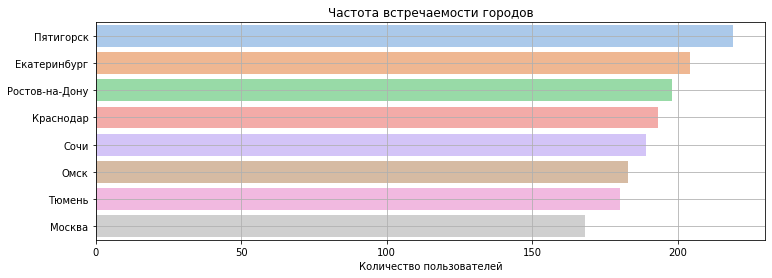

In [25]:
# рисуем
plt.figure(figsize=(12,4))
sns.barplot(y=users['city'].value_counts().index, x=users['city'].value_counts(), palette=colors)
plt.xlabel('Количество пользователей')
plt.title('Частота встречаемости городов')
plt.grid()

**Вывод:** Как видно из графика, наибольшее количество пользователей зарегистрировано в Пятигорске, наименьшее - в Москве.

### Соотношение пользователей с подпиской и без

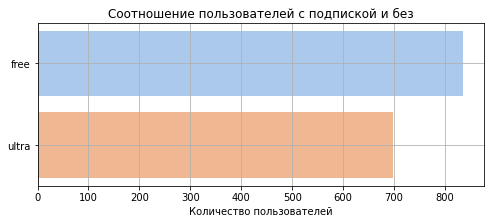

In [26]:
plt.figure(figsize=(8,3))
sns.barplot(y=users['subscription_type'].value_counts().index, x=users['subscription_type'].value_counts(), palette=colors)
plt.xlabel('Количество пользователей')
plt.title('Соотношение пользователей с подпиской и без')
plt.grid()

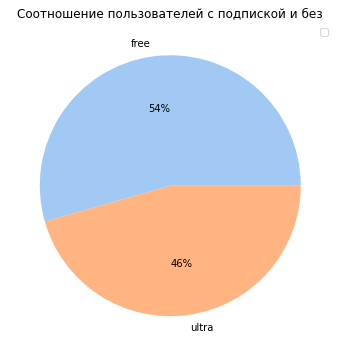

In [57]:
users_type = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
users_type.columns = ['count']

users_type.plot(y='count', kind='pie', figsize=(6,6), colors=colors, autopct='%.0f%%',\
                title='Соотношение пользователей с подпиской и без')
plt.ylabel('')
plt.legend('')
plt.show();

**Вывод:** Как видно из диаграм, количество пользователей без платной подписки больше (54%), чем пользователей с платной подпиской (46%).

### Возраст пользователей

In [58]:
print('Минимальный возраст пользователя:', users['age'].min())
print('Максимальный возраст пользователя:', users['age'].max())

Минимальный возраст пользователя: 12
Максимальный возраст пользователя: 43


In [59]:
# посмотрим. какой возраст наиболее часто встречается
users['age'].value_counts().sort_values(ascending=False).head(10)

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
Name: age, dtype: int64

In [60]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

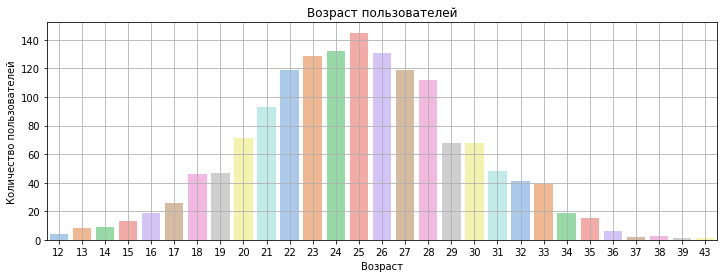

In [63]:
# строим диаграмму
plt.figure(figsize=(12,4))
sns.barplot(x=users['age'].value_counts().index, y=users['age'].value_counts(), palette=colors)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Возраст пользователей')
plt.grid()

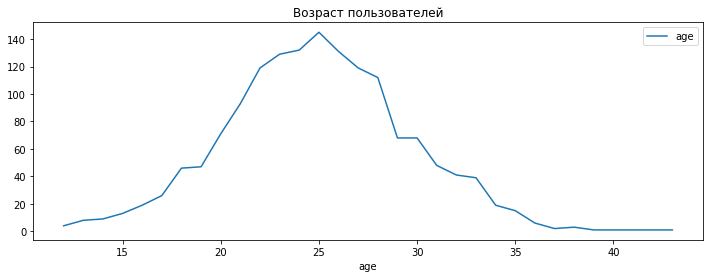

In [64]:
users.groupby('age').agg({'age': 'count'}).plot(figsize=(12,4), title='Возраст пользователей');

**Вывод:** Наиболее часто встречающаяся возрастная категория это пользователи 22-28 лет. Есть пользователи младше 18 лет, что немного смущает, возможно, техническая ошибка.

### Расстояние, которое пользователь преодолел за одну поездку

In [65]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

In [66]:
# сводная таблица со средними и медианными значениями дистанций
# distance_pivot = rides.pivot_table(index='user_id', values='distance', aggfunc=['mean', 'median'])
# distance_pivot.columns = ['mean', 'median']
# distance_pivot.head(10)

In [67]:
# строим диаграммы
# distance_pivot['mean'].hist(bins=30, alpha=0.7, rwidth=0.9, figsize=(8,4), color='blue')
# #plt.show()
# distance_pivot['median'].hist(bins=30, alpha=0.7, rwidth=0.9, figsize=(8,4), color='pink');

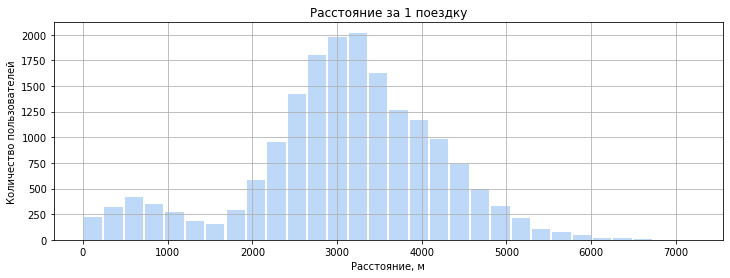

In [79]:
rides['distance'].plot(kind='hist', bins=30, grid=True, alpha=0.7, rwidth=0.9, figsize=(12,4),\
                       title='Расстояние за 1 поездку', color=colors)
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей');

**Вывод:** Наиболее часто пользователи проезжают 3 "с копейками" км, что подтверждается расчетными средним и медианным значениями. Значительно реже расстояние составляет менее 2,5 и более 3,5 кв.

### Продолжительность поездок

In [31]:
rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [32]:
# сводная таблица со средним и медианным значением продолжительности поездок
duration_pivot = rides.pivot_table(index='user_id', values='duration', aggfunc=['mean', 'median'])
duration_pivot.columns = ['mean', 'median']
duration_pivot.head(10)

,mean,median
user_id,,
1,17.583333,16.5
2,18.454545,19.0
3,19.916667,20.5
4,20.928571,21.5
5,16.363636,15.0
6,20.900000,20.0
7,16.750000,16.0
8,18.600000,17.0
9,16.625000,17.0


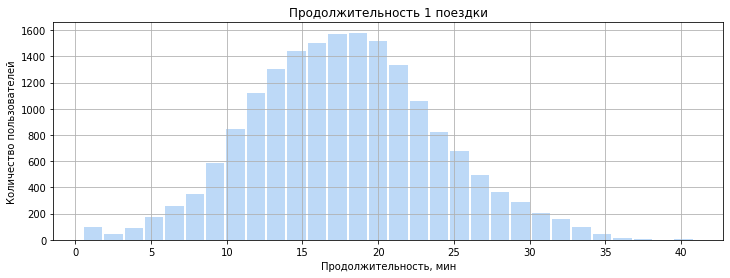

In [80]:
# диаграммы
# duration_pivot['mean'].hist(bins=30, alpha=0.7, rwidth=0.9, figsize=(8,4), range=(0, 42), color='blue')
# #plt.show()
# duration_pivot['median'].hist(bins=30, alpha=0.7, rwidth=0.9, figsize=(8,4), range=(0, 42), color='pink');
rides['duration'].plot(kind='hist', bins=30, grid=True, alpha=0.7, rwidth=0.9, figsize=(12,4),\
                       title='Продолжительность 1 поездки', color=colors)
plt.xlabel('Продолжительность, мин')
plt.ylabel('Количество пользователей');

**Вывод:** Наиболее часто пользователи арендуют самокаты на время в районе 18 минут, значительно реже - менее 15 и более 20 минут.

## Объединение данных

### Создание новых датафреймов

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [81]:
# сначала объединяем данные о пользователях и поездках по столбцу user_id
df = pd.merge(users, rides, on='user_id', how='outer')
# добавляем данные о тарифах, объединяем по столбцу subscription_type
df = pd.merge(df, subscription, on='subscription_type', how='outer')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199


In [82]:
df.shape[0]

18068

In [83]:
# проверим на пропуски на всякий случай
df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Создадим два датафрейма с данными о пользователях без подписки и с подпиской.

In [84]:
# фильтруем по типу подписки
users_free = df[df['subscription_type'] == 'free']
users_ultra = df[df['subscription_type'] == 'ultra']

In [85]:
# посмотрим датафрейм с пользователями без подписки
users_free.sample(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
12798,1160,Стефания,27,Екатеринбург,free,3054.76,23.098908,2021-09-10,9,8,50,0
8421,842,Кира,25,Пятигорск,free,905.13,6.194587,2021-08-24,8,8,50,0
9509,923,Александра,22,Екатеринбург,free,3456.72,17.522416,2021-07-03,7,8,50,0
15610,1363,Майя,29,Сочи,free,2685.88,20.743525,2021-03-19,3,8,50,0
9366,913,Зарина,31,Тюмень,free,2383.00,14.410592,2021-05-22,5,8,50,0


In [86]:
# посмотрим датафрейм с пользователями с подпиской
users_ultra.sample(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
3079,330,Мария,19,Пятигорск,ultra,3467.44,21.001781,2021-08-25,8,6,0,199
6355,682,Евгения,23,Сочи,ultra,2624.93,14.299828,2021-06-23,6,6,0,199
4621,498,Руслан,23,Ростов-на-Дону,ultra,3167.88,18.620977,2021-11-25,11,6,0,199
2380,253,Назар,23,Сочи,ultra,3319.29,18.966307,2021-04-09,4,6,0,199
6145,659,Злата,27,Ростов-на-Дону,ultra,4062.79,14.405772,2021-02-07,2,6,0,199


In [87]:
print('Количество строк в датафрейме с пользователями без подписки:', users_free.shape[0])
print('Количество строк в датафрейме с пользователями с подпиской:', users_ultra.shape[0])

Количество строк в датафрейме с пользователями без подписки: 11568
Количество строк в датафрейме с пользователями с подпиской: 6500


### Визуализация информации о расстоянии и времени поездок

In [88]:
# время и дистанция для пользователей без подписки
users_free[['distance', 'duration']].describe()

,distance,duration
count,11568.000000,11568.000000
mean,3045.495284,17.390909
std,1246.173810,6.326803
min,0.860000,0.500000
25%,2366.560000,12.958437
50%,3114.650000,17.326890
75%,3905.695000,21.594071
max,7211.010000,34.948498


In [89]:
# время и дистанция для пользователей с подпиской
users_ultra[['distance', 'duration']].describe()

,distance,duration
count,6500.000000,6500.000000
mean,3115.445431,18.541985
std,836.895369,5.572048
min,244.210000,3.760353
25%,2785.447500,14.524654
50%,3148.640000,18.178153
75%,3560.577500,21.884129
max,5699.770000,40.823963


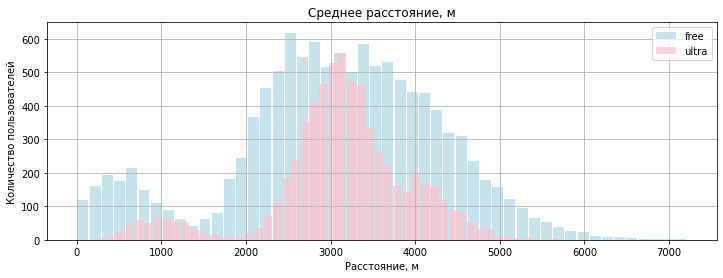

In [105]:
# диаграммы
users_free['distance']\
    .plot(kind='hist', bins=50, grid=True, alpha=0.7,\
          rwidth=0.9, figsize=(12,4), title='Среднее расстояние, м', color='lightblue', label='free')

users_ultra['distance']\
    .plot(kind='hist', bins=50, grid=True, alpha=0.7, rwidth=0.9, figsize=(12,4), color='pink', label='ultra')
plt.legend()
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей');

**Вывод:** В целом можно сделать вывод, что средние дистанции у обеих категорий примерно одинаковые, но количество пользователей без подписки больше.

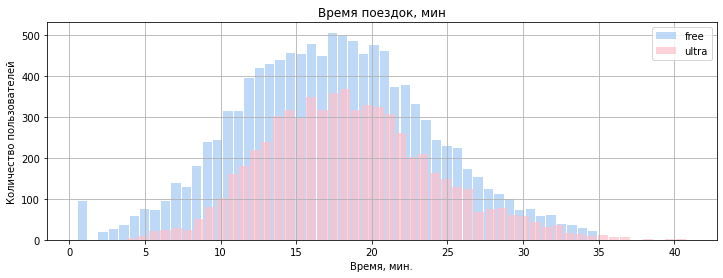

In [106]:
# users_free.groupby(['user_id'])['duration'].mean()\
#     .plot(kind='hist', bins=50, grid=True, alpha=0.7, rwidth=0.9, figsize=(12,4), title='Среднее время поездок, мин', color=colors)
# users_ultra.groupby(['user_id'])['duration'].mean()\
#     .plot(kind='hist', bins=50, grid=True, alpha=0.7, rwidth=0.9, figsize=(12,4), color='pink');

users_free['duration'].plot(kind='hist', bins=50, grid=True, alpha=0.7,\
                            rwidth=0.9, figsize=(12,4), title='Время поездок, мин', color=colors, label='free')
users_ultra['duration'].plot(kind='hist', bins=50, grid=True, alpha=0.7,\
                             rwidth=0.9, figsize=(12,4), color='pink', label='ultra')
plt.legend()
plt.xlabel('Время, мин.')
plt.ylabel('Количество пользователей');

**Вывод:** У пользователей без подписки средняя длительность поездок немного короче, чем у пользователей с платной подпиской. 

## Подсчёт выручки

Сформируем сводную таблицу с данными о количестве поездок, суммарному расстоянию и времени по месяцам для каждого пользователя.

In [111]:
# формируем сводную таблицу
revenue_df = df.pivot_table(index=['user_id', 'month', 'subscription_type'],\
                            values=['distance', 'duration'],\
                            aggfunc={'distance':['sum', 'count'], 'duration': 'sum'}).reset_index()
# revenue_df = df.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc={'distance':['sum', 'count'], 'duration': 'sum'})

# названия столбцов: количество, суммарная дистанция, суммарное время 
revenue_df.columns = ['user_id', 'month', 'subscription_type', 'count', 'distance_total', 'duration_total']
revenue_df['duration_total'] = np.ceil(revenue_df['duration_total']) 
# просмотр
revenue_df.head(10)

,user_id,month,subscription_type,count,distance_total,duration_total
0,1,1,ultra,2,7027.51,42.0
1,1,4,ultra,1,754.16,7.0
2,1,8,ultra,2,6723.47,45.0
3,1,10,ultra,2,5809.91,32.0
4,1,11,ultra,3,7003.50,54.0
5,1,12,ultra,2,6751.63,28.0
6,2,3,ultra,3,10187.73,61.0
7,2,4,ultra,2,6164.39,40.0
8,2,6,ultra,1,3255.34,14.0
9,2,7,ultra,2,6780.73,47.0


In [112]:
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   month              11331 non-null  int64  
 2   subscription_type  11331 non-null  object 
 3   count              11331 non-null  int64  
 4   distance_total     11331 non-null  float64
 5   duration_total     11331 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 531.3+ KB


Создадим функцию для расчета итого платежа за месяц с учетом типа подписки.

In [113]:
# на входе строка датафрейма, на выходе стоимость
def costs(row):
    # получаем строку с данными по тарифу из subscription, которая соответствует обрабатываемой строке
    tariff = subscription[subscription['subscription_type'] == row['subscription_type']]
     # расчет платежа за месяц: 
     # стоимость старта * кол-во поездок
     # + стоимость 1 мин*общую длительность
     # + стоимость подписки
    total_payment = float(tariff['start_ride_price']*row['count'] + tariff['minute_price']*row['duration_total'] + tariff['subscription_fee'])
    return total_payment

In [114]:
# проверка
test = revenue_df.head(5)
# test['total'] = 
test.apply(costs, axis=1)

0    451.0
1    241.0
2    469.0
3    391.0
4    523.0
dtype: float64

In [116]:
# создаем столбец со стоимостью платежа за месяц
revenue_df['payment'] = revenue_df.apply(costs, axis=1)

In [117]:
revenue_df.sample(5)

,user_id,month,subscription_type,count,distance_total,duration_total,payment
5159,779,5,free,1,3969.71,26.0,258.0
1184,182,6,ultra,1,3292.40,27.0,361.0
9187,1271,9,free,1,3644.11,31.0,298.0
1945,296,12,ultra,1,3674.25,23.0,337.0
6940,999,12,free,1,3277.48,23.0,234.0


## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.  

### Гипотеза 1.

*Задача: Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то действительно ли пользователи с подпиской «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.*

Сфорулируем нулевую и альтернативную гипотезы:  
**H0:** Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки.  
**H1:** Пользователи с подпиской тратят больше времени, чем пользователи без подписки.

Зададим уровень статистической значимости в размере 5%. Проведем t-тест.

In [118]:
alpha = 0.05

Перед проведением t-теста проверим гипотезу о равенстве дисперсий двух выборок.

In [119]:
test_leven, p = st.levene(users_ultra['duration'], users_free['duration'])
#print('Statistics = %.3f, p-value=%.3f' % (test_leven, p))

if p < alpha:
    print('Отвергаем гипотезу о равенстве дисперсий.')
else:
    print('Не получилось отвергнуть гипотезу о равенстве дисперсий.')

Отвергаем гипотезу о равенстве дисперсий.


Проведем t-тест для выборок:

In [120]:
print('Средняя длительность поездок у пользователей с подпиской:', users_ultra['duration'].mean().round(2))
print('Средняя длительность поездок у пользователей без подписки:', users_free['duration'].mean().round(2))

# делаем t-тест с учетом неравенства дисперсий
results = st.ttest_ind(users_ultra['duration'], users_free['duration'], equal_var=False, alternative='greater')

# p-значение
print('p-значение:', results.pvalue)

# сравниваем p-значение с alpha
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу о длительности поездок.')
else:
    print('Не получилось отвергнуть нулевую гипотезу о длительности поездок.')                       

Средняя длительность поездок у пользователей с подпиской: 18.54
Средняя длительность поездок у пользователей без подписки: 17.39
p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу о длительности поездок.


**Вывод:** Нулевая гипотеза о равенстве длительности поездок отвергается. Есть основания предполагать, что пользователи с подпиской тратят больше временя на поездки, что подтверждается расчетными средними значениями.

### Гипотеза 2.  
*Задача: Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.*

Сфорулируем нулевую и альтернативную гипотезы:  
**H0:** Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м.  
**H1:** Расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 м. 

In [121]:
users_ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

In [124]:
# alpha = 0.01
# оптимальное расстояние
optimal_dist = 3130
# t-тест 
results = st.ttest_1samp(users_ultra['distance'], optimal_dist, alternative='greater')

print('p-значение:', results.pvalue)
# сравниваем p-значение с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о непревышении расстояния в 3130 м.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу.


**Вывод:** Гипотеза о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м, не была отвергнута. 

### Гипотеза 3.  
*Задача: Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.*

Нулевая и альтернативная гипотезы:  
**H0:** Помесячная выручка от пользователей с подпиской равна помес. выручке от пользователей без подписки.  
**H1:** Помесячная выручка от пользователей с подпиской > помес. выручки от пользователей без подписки.

Сформируем сводную таблицу с оплатами по месяцам по каждому типу подписки.

In [130]:


revenue_month_ultra = revenue_df[revenue_df['subscription_type'] == 'ultra']

revenue_month_free = revenue_df[revenue_df['subscription_type'] == 'free']


In [127]:
#evenue_month_ultra

In [131]:
revenue_month_ultra['payment'].describe()

count    4533.000000
mean      361.481800
std        86.399966
min       223.000000
25%       301.000000
50%       331.000000
75%       403.000000
max       943.000000
Name: payment, dtype: float64

In [132]:
revenue_month_free['payment'].describe()

count    6798.000000
mean      325.842895
std       180.515646
min        58.000000
25%       194.000000
50%       268.000000
75%       420.000000
max      1428.000000
Name: payment, dtype: float64

Перед проведением t-теста проверим гипотезу о равенстве дисперсий двух выборок.

In [133]:
test_leven, p = st.levene(revenue_month_ultra['payment'], revenue_month_free['payment'])

if p < alpha:
    print('Отвергаем гипотезу о равенстве дисперсий.')
else:
    print('Не получилось отвергнуть гипотезу о равенстве дисперсий.')

Отвергаем гипотезу о равенстве дисперсий.


In [134]:
print('Средний платеж в месяц у пользователей с подпиской:', revenue_month_ultra['payment'].mean().round(2))
print('Средний платеж в месяц у пользователей без подписки:', revenue_month_free['payment'].mean().round(2))

# делаем t-тест с учетом неравенства дисперсий
results = st.ttest_ind(revenue_month_ultra['payment'], revenue_month_free['payment'], equal_var=False, alternative='greater')

# p-значение
print('p-значение:', results.pvalue)

# сравниваем p-значение с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве платежей.')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве платежей.')

Средний платеж в месяц у пользователей с подпиской: 361.48
Средний платеж в месяц у пользователей без подписки: 325.84
p-значение: 1.0718729651261336e-44
Отвергаем нулевую гипотезу о равенстве платежей.


**Вывод:** Нулевая гипотеза о равенстве помесячных платежей отвергается. Есть основания предполагать, что пользователи c подпиской приносят больше выручки, чем пользователи без подписки.

### Гипотеза 4.
*Задача: Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?*


**Решение:** Т.к. в данном случае выборки будут зависимыми/парными, для проверки гипотезы о равенстве или неравенстве/снижении количества обращений применяется метод scipy.stats.ttest_rel().

# Общий вывод

В ходе проделанной работы было выполнено:
- Изучены исходные данные.
- Проведена предобработка данных, в т.ч. смена типов данных, добавление доп. столбцов, проверка на пропуски и дубликаты.
- Проведен исследовательский анализ данных, в ходе которого сделаны следующие выводы:
 - Наибольшее количество пользователей зарегистрировано в Пятигорске, наименьшее - в Москве.
 - Пользователей с бесплатной подпиской больше (54%), чем пользователей с платной подпиской (46%).
 - Наиболее часто встречающаяся возрастная категория это пользователи 22-28 лет. 
 - В среднем пользователи обеих подписок проезжают в районе 3км.
 - У пользователей без подписки средняя длительность поездок немного короче, чем у пользователей с платной подпиской.
- Проверены гипотезы, в том числе:
 1. Гипотеза о равенстве времени поездок у пользователей с платной и бесплатной подписками.  Нулевая гипотеза о равенстве длительности поездок была отвергнута. Пользователи с подпиской тратят больше временя на поездки, что подтверждается расчетными средними значениями. 
 2. Гипотеза о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м. Гипотеза не была отвергнута.
 3. Гипотеза о том, что помесячная выручка от пользователей с подпиской равна помес. выручке от пользователей без подписки. Гипотеза о равенстве помесячных платежей была отвергнута. Пользователи с подпиской приносят больше выручки.


<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера:</b> 
    
Очень здорово, что ты сделала общий вывод!

Человек, заинтересовавшийся твоим проектом, может сразу перейти к выводу, чтобы понять нужно ли ему углубляться в изучение исследования или нет.


**Хочу обратить твое внимание на то, что после исправления замечаний в некоторых пунктах исследования могут измениться результаты, поэтому нужно будет подкорректировать выводы.**</div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
Сделано ✔
</div>